In [1]:
import polars as pl

# Load the data
df_child = pl.read_excel("data/policy_tracker.xlsx", sheet_name="4. US State - Current Child")

# Get the 4 passed bills
passed_bills = df_child.filter(
    pl.col("Status (optional)").str.contains("(?i)passed|act |chaptered")
)

print("=== PASSED BILLS - FULL TEXT ===\n")

for i, row in enumerate(passed_bills.iter_rows(named=True)):
    print(f"\n{'='*80}")
    print(f"BILL #{i+1}")
    print(f"State: {row['US State']}")
    print(f"Name: {row['Name']}")
    print(f"Intro Date: {row['Intro Date']}")
    print(f"Status: {row['Status (optional)']}")
    print(f"\nDescription:")
    print(row['Description'])
    print(f"{'='*80}")

print("\n\n=== SAMPLE OF PROPOSED BILLS ===\n")

# Get 5 random proposed bills
sample_bills = df_child.sample(5)

for i, row in enumerate(sample_bills.iter_rows(named=True)):
    print(f"\n{'='*80}")
    print(f"SAMPLE #{i+1}")
    print(f"State: {row['US State']}")
    print(f"Name: {row['Name']}")
    print(f"\nDescription:")
    print(row['Description'])
    print(f"{'='*80}")

Could not determine dtype for column 14, falling back to string


=== PASSED BILLS - FULL TEXT ===


BILL #1
State: Arkansas
Name: To create the protection of minors from distribution of harmful material act;  to establish liability for the publication or distribution of material harmful to minors on the internet;  and to require reasonable age verification.
Intro Date: 2023-01-17
Status: 4/11/2023 - Passed, now Act 612 - 100% progression

Description:
Requires age verification to access websites that are more than one-third pornography. Retaining ID information prohibited.

BILL #2
State: Arkansas
Name: To create the social media safety act;  to require age verification for use of social media;  and to clarify liability for failure to perform age verification for use of social media and illegal retention of data.
Intro Date: 2023-03-09
Status: 4/11/2023 - Passed, now Act 689 - 100% progression

Description:
Requires age verification / parental consent to open social media accounts, with significant exclusions. Retaining ID information prohibited.

B

In [ ]:
import polars as pl
import json
import os
from anthropic import Anthropic

# Set your API key
os.environ['ANTHROPIC_API_KEY'] = 'api-key'

# Initialize client
client = Anthropic()

# Load bills
df_child = pl.read_excel("data/policy_tracker.xlsx", sheet_name="4. US State - Current Child")

features_list = []

for i, bill in enumerate(df_child.to_dicts()):
    print(f"Processing {i+1}/146: {bill['US State']} - {bill['Name'][:40]}...")
    
    prompt = f"""Analyze this child safety bill. Mark TRUE only if the feature is a PRIMARY, REQUIRED mechanism of the bill.

Bill Name: {bill['Name']}
Bill Description: {bill['Description']}

Answer with ONLY valid JSON (no markdown, no explanation):

{{
  "age_verification": true/false,
  "parental_consent": true/false,
  "data_collection_limits": true/false,
  "algorithmic_restrictions": true/false,
  "duty_of_care": true/false,
  "risk_assessment_required": true/false,
  "default_privacy_settings": true/false,
  "time_limits": true/false,
  "targets_all_platforms": true/false,
  "school_based": true/false
}}

Be strict. Mark TRUE only for PRIMARY mechanisms the bill REQUIRES."""
    
    try:
        message = client.messages.create(
            model="claude-sonnet-4-20250514",
            max_tokens=1000,
            messages=[
                {"role": "user", "content": prompt}
            ]
        )
        
        # Extract JSON from response
        text = message.content[0].text
        
        # Remove markdown code blocks if present
        text = text.replace('```json', '').replace('```', '').strip()
        
        features = json.loads(text)
        features['state'] = bill['US State']
        features['name'] = bill['Name']
        features_list.append(features)
        
        # Show what it classified
        true_features = [k for k, v in features.items() if v == True and k not in ['state', 'name']]
        if true_features:
            print(f"  ✓ {', '.join(true_features)}")
        else:
            print(f"  ✓ No primary mechanisms detected")
            
    except Exception as e:
        print(f"  ✗ Error: {e}")

# Save results
with open('bill_features_claude.json', 'w') as f:
    json.dump(features_list, f, indent=2)

features_df = pl.DataFrame(features_list)

print("\n\n=== CLAUDE CLASSIFICATION RESULTS ===")
print(f"Total bills processed: {len(features_list)}/146\n")

for col in ['age_verification', 'parental_consent', 'data_collection_limits', 
            'algorithmic_restrictions', 'duty_of_care', 'risk_assessment_required',
            'default_privacy_settings', 'time_limits', 'targets_all_platforms', 'school_based']:
    count = features_df[col].sum()
    print(f"{col}: {count}/{len(features_list)} bills ({count/len(features_list)*100:.1f}%)")

# Spot check: Show some age verification bills
age_verify_bills = features_df.filter(pl.col('age_verification') == True)
print(f"\n\n=== BILLS WITH AGE VERIFICATION ({len(age_verify_bills)}) ===")
print(age_verify_bills.select(['state', 'name']).head(10))

Could not determine dtype for column 14, falling back to string


Processing 1/146: Alabama - Relating to consumer protection;  to req...
  ✓ default_privacy_settings
Processing 2/146: Arizona - To create the protection of minors from ...
  ✓ age_verification
Processing 3/146: Arkansas - To create the protection of minors from ...
  ✓ age_verification
Processing 4/146: Arkansas - To create the social media safety act;  ...
  ✓ age_verification, parental_consent, data_collection_limits
Processing 5/146: California - Business regulations: sexually explicit ...
  ✓ age_verification, data_collection_limits
Processing 6/146: California - The California Age-Appropriate Design Co...
  ✓ age_verification, data_collection_limits, risk_assessment_required
Processing 7/146: California - Features that harm child users: civil pe...
  ✓ algorithmic_restrictions, duty_of_care, risk_assessment_required, targets_all_platforms
Processing 8/146: California - Social media platforms: minor users: civ...
  ✓ algorithmic_restrictions, targets_all_platforms
Processing 9/146

In [24]:
# Save the results
with open('bill_features_claude.json', 'w') as f:
    json.dump(features_list, f, indent=2)

features_df.write_csv('bill_features_claude.csv')

print("✅ Saved Claude classification results")
print("\nReady for paradigm analysis!")

✅ Saved Claude classification results

Ready for paradigm analysis!


In [21]:
import polars as pl
import json

# Load Claude results
with open('bill_features_claude.json', 'r') as f:
    features_list = json.load(f)

features_df = pl.DataFrame(features_list)

print(f"Total bills: {len(features_df)}\n")

# Define paradigm classification logic
def classify_paradigm(row):
    """
    Classify bills into policy paradigms based on feature combinations
    """
    
    # Access Control: Age verification + parental consent (restricting access)
    if row['age_verification'] and row['parental_consent']:
        return "Access Control"
    
    # Privacy-First: Data limits + default privacy (protecting data)
    elif row['data_collection_limits'] and row['default_privacy_settings']:
        return "Privacy-First"
    
    # Platform Responsibility: Duty of care + algorithmic restrictions (platform design)
    elif row['duty_of_care'] or (row['algorithmic_restrictions'] and row['risk_assessment_required']):
        return "Platform Responsibility"
    
    # Educational: School-based interventions
    elif row['school_based']:
        return "Educational"
    
    # Age Verification Only (common for pornography-specific bills)
    elif row['age_verification'] and not row['parental_consent']:
        return "Age Verification Only"
    
    # Data Privacy Only
    elif row['data_collection_limits'] and not row['default_privacy_settings']:
        return "Data Privacy Only"
    
    # Hybrid/Complex (multiple mechanisms that don't fit clear patterns)
    elif sum([row['age_verification'], row['parental_consent'], row['data_collection_limits'], 
              row['algorithmic_restrictions'], row['duty_of_care']]) >= 3:
        return "Hybrid/Comprehensive"
    
    # Procedural (no primary mechanisms - enforcement, task forces, etc.)
    else:
        return "Procedural/Other"

# Apply classification
paradigm_list = []
for row_dict in features_df.to_dicts():
    paradigm = classify_paradigm(row_dict)
    paradigm_list.append(paradigm)

# Add paradigm column
features_df = features_df.with_columns(
    pl.Series("paradigm", paradigm_list)
)

# Show paradigm breakdown
print("=== POLICY PARADIGM CLASSIFICATION ===\n")
paradigm_counts = features_df.group_by("paradigm").agg(
    pl.len().alias("count")
).sort("count", descending=True)

print(paradigm_counts)

# Show examples of each paradigm
print("\n\n=== EXAMPLES BY PARADIGM ===\n")

for paradigm in paradigm_counts['paradigm'].to_list():
    print(f"\n{paradigm.upper()} ({features_df.filter(pl.col('paradigm') == paradigm).shape[0]} bills)")
    examples = features_df.filter(pl.col('paradigm') == paradigm).select(['state', 'name']).head(3)
    for row in examples.iter_rows(named=True):
        print(f"  • {row['state']}: {row['name'][:60]}")

# Save with paradigm classifications
with open('bill_features_with_paradigms.json', 'w') as f:
    json.dump(features_df.to_dicts(), f, indent=2)

features_df.write_csv('bill_features_with_paradigms.csv')

print("\n\n✅ Saved bills with paradigm classifications")

Total bills: 145

=== POLICY PARADIGM CLASSIFICATION ===

shape: (6, 2)
┌─────────────────────────┬───────┐
│ paradigm                ┆ count │
│ ---                     ┆ ---   │
│ str                     ┆ u32   │
╞═════════════════════════╪═══════╡
│ Procedural/Other        ┆ 59    │
│ Data Privacy Only       ┆ 40    │
│ Platform Responsibility ┆ 21    │
│ Privacy-First           ┆ 13    │
│ Educational             ┆ 6     │
│ Age Verification Only   ┆ 6     │
└─────────────────────────┴───────┘


=== EXAMPLES BY PARADIGM ===


PROCEDURAL/OTHER (59 bills)
  • Arizona: To create the protection of minors from distribution of harm
  • Arkansas: To create the protection of minors from distribution of harm
  • California: Business regulations: sexually explicit material 

DATA PRIVACY ONLY (40 bills)
  • Arkansas: To create the social media safety act;  to require age verif
  • California: Social media platforms: minor users: civil penalties
  • Connecticut: An act concerning minors and 

✅ Saved: child_safety_analysis.png


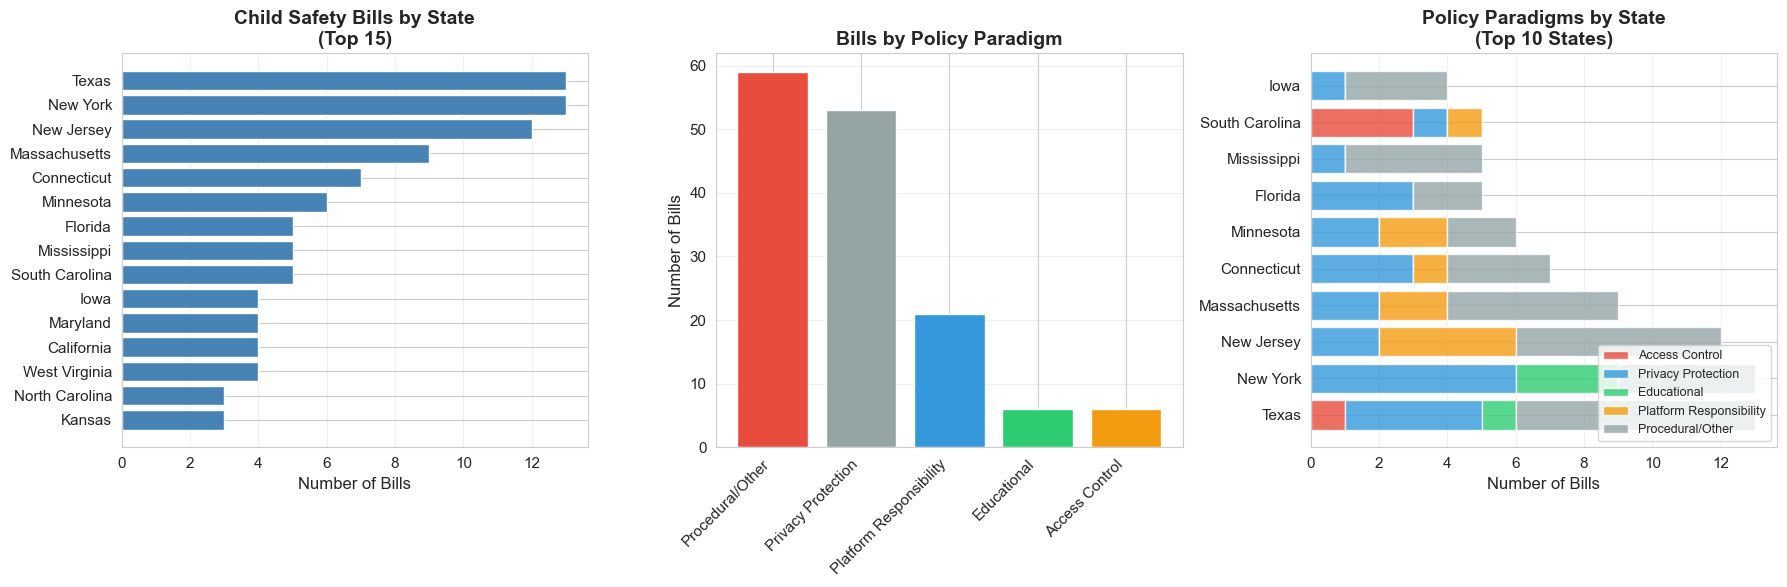

In [22]:
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import json

# Load the data
with open('bill_features_with_paradigms.json', 'r') as f:
    data = json.load(f)

features_df = pl.DataFrame(data)

# Recreate paradigm_group if needed
if 'paradigm_group' not in features_df.columns:
    def group_paradigms(paradigm):
        if paradigm in ['Age Verification Only', 'Access Control']:
            return 'Access Control'
        elif paradigm in ['Data Privacy Only', 'Privacy-First']:
            return 'Privacy Protection'
        elif paradigm == 'Platform Responsibility':
            return 'Platform Responsibility'
        elif paradigm == 'Educational':
            return 'Educational'
        else:
            return 'Procedural/Other'
    
    paradigm_groups = [group_paradigms(p) for p in features_df['paradigm'].to_list()]
    features_df = features_df.with_columns(pl.Series("paradigm_group", paradigm_groups))

# Create 3-panel figure
sns.set_style("whitegrid")
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

# ===== PLOT 1: Bills by State (Top 15) =====
state_counts = features_df.group_by("state").agg(
    pl.len().alias("count")
).sort("count", descending=True).head(15)

ax1.barh(state_counts['state'].to_list()[::-1], state_counts['count'].to_list()[::-1], color='steelblue')
ax1.set_xlabel('Number of Bills', fontsize=12)
ax1.set_title('Child Safety Bills by State\n(Top 15)', fontsize=14, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# ===== PLOT 2: Bills by Paradigm =====
paradigm_counts = features_df.group_by("paradigm_group").agg(
    pl.len().alias("count")
).sort("count", descending=True)

colors = ['#e74c3c', '#95a5a6', '#3498db', '#2ecc71', '#f39c12']
ax2.bar(range(len(paradigm_counts)), paradigm_counts['count'].to_list(), color=colors)
ax2.set_ylabel('Number of Bills', fontsize=12)
ax2.set_title('Bills by Policy Paradigm', fontsize=14, fontweight='bold')
ax2.set_xticks(range(len(paradigm_counts)))
ax2.set_xticklabels(paradigm_counts['paradigm_group'].to_list(), rotation=45, ha='right')
ax2.grid(axis='y', alpha=0.3)

# ===== PLOT 3: Paradigms by Top 10 States (Stacked Bar) =====
top_10_states = state_counts.head(10)['state'].to_list()

# Get paradigm distribution for each top state
state_paradigm_data = {}
for state in top_10_states:
    state_bills = features_df.filter(pl.col('state') == state)
    paradigm_dist = state_bills.group_by('paradigm_group').agg(pl.len().alias('count'))
    state_paradigm_data[state] = {row['paradigm_group']: row['count'] for row in paradigm_dist.to_dicts()}

# Prepare stacked bar data
paradigm_order = ['Access Control', 'Privacy Protection', 'Educational', 'Platform Responsibility', 'Procedural/Other']
colors_dict = {
    'Access Control': '#e74c3c',
    'Privacy Protection': '#3498db', 
    'Educational': '#2ecc71',
    'Platform Responsibility': '#f39c12',
    'Procedural/Other': '#95a5a6'
}

# Build stacked bars
bottoms = [0] * len(top_10_states)
for paradigm in paradigm_order:
    counts = [state_paradigm_data[state].get(paradigm, 0) for state in top_10_states]
    ax3.barh(range(len(top_10_states)), counts, left=bottoms, 
             label=paradigm, color=colors_dict[paradigm], alpha=0.8)
    bottoms = [b + c for b, c in zip(bottoms, counts)]

ax3.set_yticks(range(len(top_10_states)))
ax3.set_yticklabels(top_10_states)
ax3.set_xlabel('Number of Bills', fontsize=12)
ax3.set_title('Policy Paradigms by State\n(Top 10 States)', fontsize=14, fontweight='bold')
ax3.legend(loc='lower right', fontsize=9)
ax3.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('child_safety_analysis.png', dpi=300, bbox_inches='tight')
print("✅ Saved: child_safety_analysis.png")
plt.show()